In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
from PIL import Image
import os 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchinfo import summary
import torchvision.models as models

# 전처리 & dataset 생성

In [2]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [3]:
file_dir = './8moods'
imgDS = ImageFolder(root = file_dir, transform = preprocessing)

In [4]:
print(imgDS.class_to_idx)

{'angry_mood': 0, 'anxiety_mood': 1, 'depressed_mood': 2, 'dynamic_mood': 3, 'happy_mood': 4, 'peaceful_mood': 5, 'tired_mood': 6, 'withered_mood': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


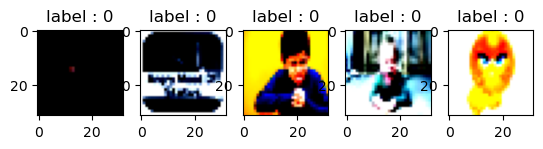

In [5]:
k = 1
for (img, label) in imgDS:
    plt.subplot(1,5,k)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"label : {label}")
    k += 1
    if k == 6 : break
plt.show()


In [6]:
seed = torch.Generator().manual_seed(42)
train, val, test = 0.7, 0.1, 0.2
trainDS, validDS, testDS = random_split(imgDS, [train, val, test], generator = seed)

# DataLoader

In [7]:
# 각 분류별로 dataloader를 생성해보자
batch_size = 10
train_dl = DataLoader(trainDS, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(validDS, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True)

1개의 배치 안에 있는 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


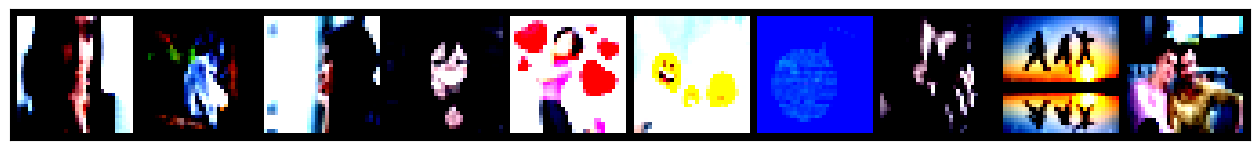

In [8]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for (images, labels) in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# model class 생성

cnn은 합성곱층, 풀링층, 벡터화층, 전결합층이 필요하다!

In [9]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
                                       # 채널 수          커널수         커널 사이즈, 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)   # class는 총 8개
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)    # 차원을 변경함
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

# 학습 위한 변수 선언

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01) # lr은 default로 함

In [11]:
model

model(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=8, bias=True)
)

# 함수 만들긔

In [12]:
import torchmetrics as mt
# 배치 크기는 10 , class 개수는 8

In [13]:
def training(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)

        # 손실계산
        loss = loss_fn(pred, target)

        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())
        
    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss, total_acc

# training(train_dl)

In [14]:
def testing(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)

        # 손실계산
        loss = loss_fn(pred, target)

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())

    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss, total_acc

In [15]:
EPOCH = 5
train_list = [[], []]
val_list = [[], []]
for epo in range(EPOCH):
    loss, acc = training(train_dl)
    train_list[0].append(loss)
    train_list[1].append(acc)

    loss, acc = testing(valid_dl)
    val_list[0].append(loss)
    val_list[1].append(acc)
    print('.', end = ' ')
    
    if epo%50 == 0 : print(epo)
print('DONE')

C:\Users\kdp\AppData\Local\Temp\ipykernel_18028\1619754934.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


. 0
. . . . DONE


In [16]:
epo_list = [ k for k in range(1, EPOCH+1)]

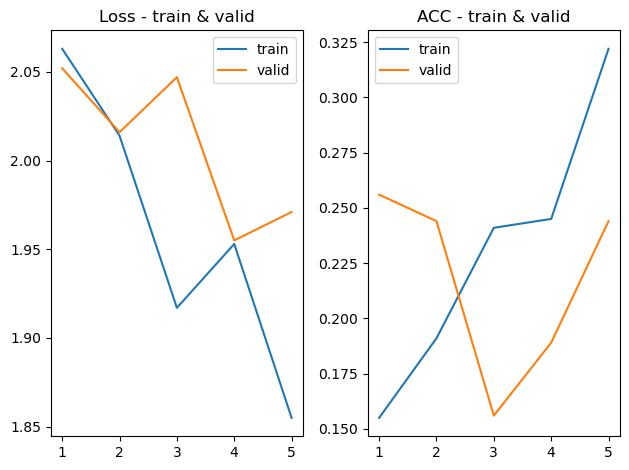

In [17]:
plt.subplot(1,2,1)
plt.plot(epo_list, train_list[0], label = 'train')
plt.plot(epo_list, val_list[0], label = 'valid')
plt.legend()
plt.title('Loss - train & valid')

plt.subplot(1,2,2)
plt.plot(epo_list, train_list[1], label = 'train')
plt.plot(epo_list, val_list[1], label = 'valid')
plt.legend()
plt.title('ACC - train & valid')

plt.tight_layout()
plt.show()

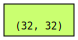

In [18]:
from torchviz import make_dot
y_pred = torch.randint(low = 0, high = 255, size = (32, 32) )
make_dot(y_pred, params = dict(model.named_parameters()))

# 모델 저장